# Predicting Employee Attrition 

# Steps:
## 1. Data Exploration, Cleaning, feature engineering
## 2. Statistical model building
## 3. Dealing with Class Imbalance
## 4. Statistical model evaluation, hyperparameter tuning
## 5. Feature Importance, selection of the best model

#### Decision tree has a good interpretability so the machine learning using DecisionTreeClassifier

## Importing required python libraries

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## The dataset was downloaded from github and was having different test and train files.
## I have merged two csv files using 'concat' function in pandas to form a single dataframe

In [2]:
emp1 = pd.read_csv("HR_train.csv")
emp2 = pd.read_csv("HR_test.csv")
emp_org = pd.concat([emp1,emp2],axis = 0)
emp = pd.concat([emp1,emp2],axis = 0)

## The shape of dataframe -

In [3]:
print(emp.shape)

(12999, 10)


## Print out top 5 rows of dataset to get a general uderstanding

In [4]:
emp.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.56,0.89,4,263,3,0,0,0,accounting,low
1,0.91,0.94,5,159,3,0,0,0,technical,low
2,0.36,0.95,6,276,2,0,0,0,support,low
3,0.56,0.59,4,164,3,0,0,1,support,medium
4,0.77,0.73,3,201,10,0,0,0,management,high


## Now we need to explore the dataset in order to know the nature of different variables(columns)

In [5]:
print(emp.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 2998
Data columns (total 10 columns):
satisfaction_level       12999 non-null float64
last_evaluation          12999 non-null float64
number_project           12999 non-null int64
average_montly_hours     12999 non-null int64
time_spend_company       12999 non-null int64
Work_accident            12999 non-null int64
left                     12999 non-null int64
promotion_last_5years    12999 non-null int64
department               12999 non-null object
salary                   12999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


#### From above output, it is clear that the dataset contains two variables in string format; department and salary; both of which are categorical variables

## let's know more about categorical variables in our dataset

In [6]:
print('Unique values for variable - deparment : {}\n\n=> so there are {} departments'
      .format(emp.department.unique(),emp.department.nunique()))

Unique values for variable - deparment : ['accounting' 'technical' 'support' 'management' 'product_mng' 'sales'
 'RandD' 'IT' 'hr' 'marketing']

=> so there are 10 departments


#### The variable 'department' is a Nominal variable and has 10 unique values

In [7]:
print('Unique values for variable - salary : {}\n\n=> so there are {} salary levels'
      .format(emp.salary.unique(),emp.salary.nunique()))

Unique values for variable - salary : ['low' 'medium' 'high']

=> so there are 3 salary levels


#### The variable 'salary' is an Ordinal variable and has 3 unique levels 

## Establishing 'salary' to an ordinal variable

In [8]:
emp.salary = emp.salary.astype('category')
emp.salary = emp.salary.cat.reorder_categories(['low','medium','high'])
emp.salary = emp.salary.cat.codes

## Transforming 'department' into a nominal variable

In [9]:
departments = pd.get_dummies(emp.department)
departments.head()

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0


#### This process is referred to as one hot encoding. A 10 dimentional vector is created and any vector chosen at random refers to the category which has 1 as a value with other dimentions valued 0.

## Given below is the illustration of how to identify the category given a 10-D vector

In [10]:
mat = np.zeros((10,10))
for i in range(10):
    mat[i,i] = 1
department_simplified = pd.DataFrame(mat,columns = departments.columns)
for i in emp.department.unique():
    department_simplified[i] = department_simplified[i].apply(lambda x : int(x))
department_simplified['category'] = department_simplified.columns

In [11]:
department_simplified

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,category
0,1,0,0,0,0,0,0,0,0,0,IT
1,0,1,0,0,0,0,0,0,0,0,RandD
2,0,0,1,0,0,0,0,0,0,0,accounting
3,0,0,0,1,0,0,0,0,0,0,hr
4,0,0,0,0,1,0,0,0,0,0,management
5,0,0,0,0,0,1,0,0,0,0,marketing
6,0,0,0,0,0,0,1,0,0,0,product_mng
7,0,0,0,0,0,0,0,1,0,0,sales
8,0,0,0,0,0,0,0,0,1,0,support
9,0,0,0,0,0,0,0,0,0,1,technical


In [12]:
matrix = np.zeros((10,9))
for i in range(9):
    matrix[i,i] = 1
df = pd.DataFrame(matrix,columns = departments.columns[:-1])
for i in departments.columns[:-1]:
    df[i] = df[i].apply(lambda x : int(x))
df['category'] = departments.columns

It is a general practice to drop one variable from the dummy variables. If we drop 'technical' from dummy variables, 

the vectors representing the categories will be 9 dimentional; and 'technical' will be represented as [0,0,0,0,0,0,0,0,0]

![abc](img/Capture.png)

Since in machine learning, geometric distance between two objects define similarity, this will add unwanted bias in our dataset. The Euclidean distance between 'technical' and all other vectors will be 1, whereas Euclidean distance between all other pairs will be 2^(0.5). 

So I have not dropped any dummy variable



## Joining dummy variables for department to the main dataframe

In [13]:
emp = emp.drop('department',axis = 1)
emp = emp.join(departments)
emp.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.56,0.89,4,263,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0
0,0.56,0.89,4,263,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0,0.37,0.49,2,138,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0
0,0.37,0.49,2,138,3,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.91,0.94,5,159,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Calculating the percentage of people who continued VS those who left

In [14]:
num_employees = len(emp)
print(emp.left.value_counts()/num_employees*100)

0    76.04885
1    23.95115
Name: left, dtype: float64


#### 23.95% employees have left the company

## Plotting correlation matrix 

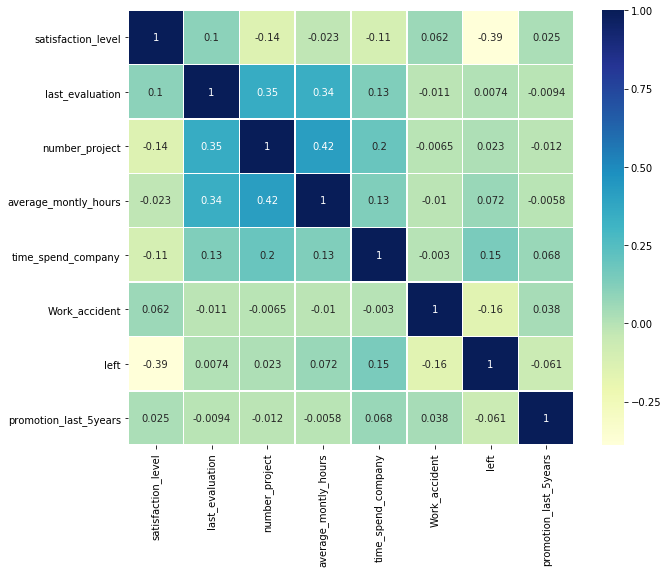

In [15]:
plt.subplots(figsize=(10,8))
correlation = emp_org.corr()
sns.heatmap(correlation, annot = True,linewidth = 0.5, cmap = "YlGnBu")
plt.show()

#### It is clear that the satisfaction level and churn(left) have a negative correlation which seems obvious

## Now let's capture dependent variable(left) in y and independent features in X

In [19]:
y = pd.DataFrame(emp.left)
X = emp.drop("left", axis = 1)

In [21]:
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size = 0.25, random_state = 42)

## Building a Decision tree model and training it over the training set & calculating score on the test set

In [25]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [26]:
print('training set accuracy = {} %\ntest set accuracy = {} %'
      .format(tree.score(X_train, y_train)*100,tree.score(X_test, y_test)*100))

training set accuracy = 100.0 %
test set accuracy = 98.25263157894737 %


In [29]:
export_graphviz(tree,"tree.dot")

#### the content of tree.dot file can be copied and pasted on http://www.webgraphviz.com/ to view the decision tree graph

## The accuracy on training set is 100% but on test set is 98.25%. This is a case of overfitting. We need to tune the parameters of decision tree in order to reduce overfitting.. This can be achieved by limiting the depth and/or the number of samples in each leaf.

In [70]:
tree_depth_5 = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_depth_5.fit(X_train, y_train)
print('training set accuracy = {} %\ntest set accuracy = {} %'
      .format(tree_depth_5.score(X_train, y_train)*100,tree_depth_5.score(X_test, y_test)*100))

training set accuracy = 97.55036147960973 %
test set accuracy = 97.32631578947368 %


In [36]:
tree_sample_100 = DecisionTreeClassifier(min_samples_leaf=100, random_state=42)
tree_sample_100.fit(X_train, y_train)
print('training set accuracy = {} %\ntest set accuracy = {} %'
      .format(tree_sample_100.score(X_train, y_train)*100,tree_sample_100.score(X_test, y_test)*100))

training set accuracy = 96.68000280760862 %
test set accuracy = 96.63157894736842 %


### Checking the precision score of the model

In [45]:
y_pred = tree.predict(X_test)
print('precision score = {}\nrecall score = {}\nroc_auc_score = {}'
      .format(precision_score(y_test, y_pred),recall_score(y_test, y_pred),roc_auc_score(y_test, y_pred)))

precision score = 0.9557522123893806
recall score = 0.9703504043126685
roc_auc_score = 0.9783014050708242


## Dealing with class imbalance
#### Class imbalance can affect predictions. We should assign equal weights to both the classes to address this problem. This can be achieved by setting class_weight parameter of the DecisionTreeClassifier to "balanced".

### Let's compare recall and roc-auc scores for balanced and imbalanced models with max_depth = 5

In [71]:
tree_depth_5 = DecisionTreeClassifier(max_depth=5,min_samples_leaf = 50, random_state=42)
tree_depth_5.fit(X_train, y_train)
y_pred_5 = tree_depth_5.predict(X_test)
print('Imbalanced Model-\nrecall_score = {}\nroc_auc_score = {}'
      .format(recall_score(y_test, y_pred_5)*100,roc_auc_score(y_test, y_pred_5)*100))

Imbalanced Model-
recall_score = 90.56603773584906
roc_auc_score = 94.58189156520251


In [72]:
tree_depth_5_balanced = DecisionTreeClassifier(max_depth=5,min_samples_leaf = 50, class_weight="balanced", random_state=42)
tree_depth_5_balanced.fit(X_train, y_train)
y_pred_5_b = tree_depth_5_balanced.predict(X_test)
print('Balanced Model-\nrecall_score = {}\nroc_auc_score = {}'
      .format(recall_score(y_test, y_pred_5_b)*100,roc_auc_score(y_test, y_pred_5_b)*100))

Balanced Model-
recall_score = 93.26145552560648
roc_auc_score = 93.3175575675874


## Hyperparameter Tuning

In [64]:
print(cross_val_score(tree_depth_5_balanced,X,y,cv=10))

[0.93263158 0.94       0.94105263 0.92368421 0.92947368 0.93263158
 0.92526316 0.92680358 0.94470774 0.94470774]


In [91]:
max_depth = [i for i in range(3,21,1)]
samples = [i for i in range(50,500,50)]
parameters = dict(max_depth=max_depth, min_samples_leaf=samples)
print(parameters)

{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_leaf': [50, 100, 150, 200, 250, 300, 350, 400, 450]}


In [92]:
search_params = GridSearchCV(tree, parameters)
search_params.fit(X_train, y_train)
print('best parameters : {}'.format(search_params.best_params_))

best parameters : {'max_depth': 5, 'min_samples_leaf': 50}


## Knowing the important features

In [86]:
feature_importance = tree_depth_5_balanced.feature_importances_
imp = pd.DataFrame(index=list(X), data=feature_importance, columns=["importance"])
imp.sort_values(by = 'importance', ascending = False)

,importance
satisfaction_level,0.457616
time_spend_company,0.379970
last_evaluation,0.103061
average_montly_hours,0.056134
number_project,0.003218
hr,0.000000
support,0.000000
sales,0.000000
product_mng,0.000000
marketing,0.000000


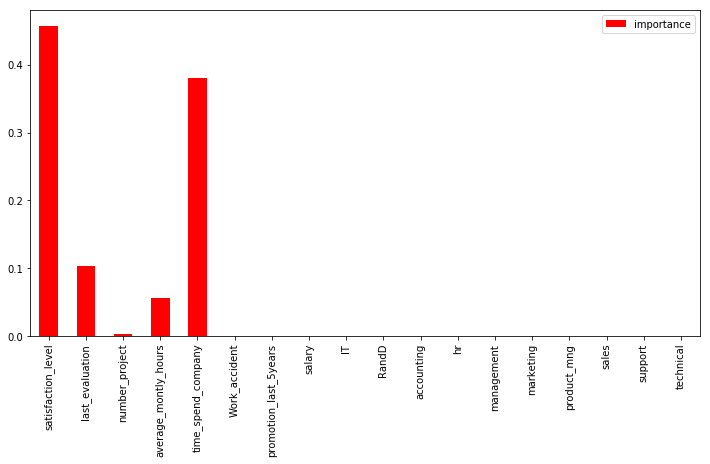

In [118]:
imp.plot(kind = 'bar', figsize = (12,6),color = 'r')

### satisfaction level and time spent at the company are top 2 important features

## Selecting features with importance higher than 1%

In [88]:
select_features = imp[imp['importance']>=0.01]
select_list = select_features.index
X_train_selected = X_train[select_list]
X_test_selected = X_test[select_list]

## Applying the best model with selected features and tuned hyperparamaters

In [104]:
best_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, class_weight="balanced",random_state=42)
best_model.fit(X_train_selected, y_train)
y_pred_best = best_model.predict(X_test_selected)
print("For the best model:-\naccuracy score = {}\nrecall score = {}\nroc-auc score = {}"
     .format(best_model.score(X_test_selected,y_test),recall_score(y_test, y_pred_best),roc_auc_score(y_test, y_pred_best)))

For the best model:-
accuracy score = 0.9334736842105263
recall score = 0.9326145552560647
roc-auc score = 0.9331755756758741


# Thank You!!!